In [2]:
import os
os.chdir('/Jigsaw capstone project')
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [5]:
data=pd.read_csv('Telecom_customer churn.csv')

##  Data Quality Report

In [6]:
data.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.997500,219.250000,22.500000,0.247500,0.000000,0.000000,0.000000,0.000000,0.000000,-157.250000,...,0.000000,N,U,U,U,U,U,Y,361.000000,1000001
1,57.492500,482.750000,37.425000,0.247500,22.750000,9.100000,9.100000,0.000000,0.000000,532.250000,...,0.000000,Z,U,U,U,U,U,Y,240.000000,1000002
2,16.990000,10.250000,16.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.250000,...,0.000000,N,U,Y,U,U,U,Y,1504.000000,1000003
3,38.000000,7.500000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.500000,...,0.000000,U,Y,U,U,U,U,Y,1812.000000,1000004
4,55.230000,570.500000,71.980000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.500000,...,0.000000,I,U,U,U,U,U,Y,434.000000,1000005


In [7]:
##Generate Data Quality Report
def Data_Q(x):
    m=x.isna().sum()
    df=pd.DataFrame(m,columns=['missing'])
    desc=x.describe().transpose().drop(['std','count'],axis=1)
    df=pd.concat([df,desc],axis=1,sort=False)
    df['TotalRecords']=x.shape[0]
    df['MissingPercent']=(df['missing']/df['TotalRecords'])*100
    df['AvailableRecords']=(df['TotalRecords']-df['missing'])
    df['AvailablePercent']=(df['AvailableRecords']/df['TotalRecords'])*100
    df['type']=x.dtypes
    uni=[]
    for i in x.columns:
        uni.append(x[i].nunique())
    df['UniqueRecords']=uni
    for i in x.columns:
        if df.loc[i]['type']!='object':
            df['5%']=x.quantile(0.05)
            df['10%']=x.quantile(0.10)
            df['90%']=x.quantile(0.90)
            df['95%']=x.quantile(0.95)
        else:
            df['5%']=0
            df['10%']=0
            df['90%']=0
            df['95%']=0   
    df.reset_index(inplace=True)
    df.rename(columns={'index':'variable_name'},inplace=True)
    df=df[['variable_name','type','TotalRecords','UniqueRecords','AvailableRecords','AvailablePercent','missing','MissingPercent','min','max','mean','5%', '10%', '25%', '50%', '75%','90%', '95%']]
    return df

In [8]:
QualityReport=Data_Q(data)

In [9]:
QualityReport.head()

,variable_name,type,TotalRecords,UniqueRecords,AvailableRecords,AvailablePercent,missing,MissingPercent,min,max,mean,5%,10%,25%,50%,75%,90%,95%
0,rev_Mean,float64,100000,37468,99643,99.643000,357,0.357000,-6.167500,3843.262500,58.719985,15.000000,25.083000,33.260000,48.195000,70.750000,103.982500,135.968500
1,mou_Mean,float64,100000,9730,99643,99.643000,357,0.357000,0.000000,12206.750000,513.559937,17.000000,48.250000,150.750000,355.500000,703.000000,1178.200000,1547.475000
2,totmrc_Mean,float64,100000,8491,99643,99.643000,357,0.357000,-26.915000,409.990000,46.179136,10.000000,18.519500,30.000000,44.990000,59.990000,74.990000,84.990000
3,da_Mean,float64,100000,172,99643,99.643000,357,0.357000,0.000000,159.390000,0.888828,0.000000,0.000000,0.000000,0.247500,0.990000,2.475000,4.207500
4,ovrmou_Mean,float64,100000,2638,99643,99.643000,357,0.357000,0.000000,4320.750000,41.072247,0.000000,0.000000,0.000000,2.750000,42.000000,119.250000,195.250000


## Data Processing

In [10]:
##Dropping columns with more than 15 percent of missing data based on Data Quality Report 
l=list(QualityReport[QualityReport['MissingPercent']>=15]['variable_name'])
data_1=data.drop(l,axis=1)

In [11]:
QualityReport=QualityReport[QualityReport['MissingPercent']<15]

In [12]:
##Finding missing values for object type variable
def missing_obj():
    l=[]
    l=QualityReport[(QualityReport['missing']>=0) & (QualityReport['type']=='object')]['variable_name']
    for i in l:
        maximum=data_1.groupby(i)[i].count().sort_values(ascending=False).index[0]
        data_1[i].fillna(maximum,inplace=True)
    

In [13]:
missing_obj()

In [14]:
QualityReport=Data_Q(data_1)

In [15]:
##finding missing values for float type variables with only 2 unique records and converting them to int type
def missing_int():
    to_int=list(QualityReport[(QualityReport['type']=='float') & (QualityReport['UniqueRecords']<10)]['variable_name'])
    for i in to_int:
        missing_index=data_1[data_1[i].isna()].index
        for j in missing_index:
            data_1.at[j,i]=data_1.groupby(i)[i].count().sort_values(ascending=False).index[0]
        data_1[i]=pd.Series.astype(data_1[i],int)
missing_int()

In [16]:
QualityReport=Data_Q(data_1)

In [17]:
QualityReport.sort_values(by='MissingPercent',ascending=False,inplace=True)
QualityReport.head(25)
#QualityReport[(QualityReport['type']=='float64') & (QualityReport['missing']>1) & (QualityReport['UniqueRecords']>40)]

,variable_name,type,TotalRecords,UniqueRecords,AvailableRecords,AvailablePercent,missing,MissingPercent,min,max,mean,5%,10%,25%,50%,75%,90%,95%
67,avg6mou,float64,100000,2941,97161,97.161000,2839,2.839000,0.000000,7217.000000,509.634576,27.000000,61.000000,163.000000,363.000000,698.000000,1149.000000,1491.000000
68,avg6qty,float64,100000,1376,97161,97.161000,2839,2.839000,0.000000,3256.000000,178.365157,11.000000,24.000000,59.000000,127.000000,237.000000,388.000000,514.000000
69,avg6rev,float64,100000,451,97161,97.161000,2839,2.839000,-2.000000,866.000000,58.683618,17.000000,29.000000,34.000000,50.000000,71.000000,102.000000,130.000000
9,change_mou,float64,100000,7711,99109,99.109000,891,0.891000,-3875.000000,31219.250000,-13.933818,-388.150000,-239.500000,-87.000000,-6.250000,63.000000,207.000000,346.000000
10,change_rev,float64,100000,32537,99109,99.109000,891,0.891000,-1107.740000,9963.657500,-1.021067,-48.003500,-28.278500,-7.365000,-0.315000,1.642500,22.344500,47.392500
74,hnd_price,float64,100000,17,99153,99.153000,847,0.847000,9.989998,499.989990,101.875763,29.989990,29.989990,29.989990,99.989990,149.989990,199.989990,199.989990
0,rev_Mean,float64,100000,37468,99643,99.643000,357,0.357000,-6.167500,3843.262500,58.719985,15.000000,25.083000,33.260000,48.195000,70.750000,103.982500,135.968500
2,totmrc_Mean,float64,100000,8491,99643,99.643000,357,0.357000,-26.915000,409.990000,46.179136,10.000000,18.519500,30.000000,44.990000,59.990000,74.990000,84.990000
3,da_Mean,float64,100000,172,99643,99.643000,357,0.357000,0.000000,159.390000,0.888828,0.000000,0.000000,0.000000,0.247500,0.990000,2.475000,4.207500
4,ovrmou_Mean,float64,100000,2638,99643,99.643000,357,0.357000,0.000000,4320.750000,41.072247,0.000000,0.000000,0.000000,2.750000,42.000000,119.250000,195.250000


In [18]:
#dropping 1 common missing value for phones,eqpdays,models variables
drop=data[data['phones'].isna()]['eqpdays'].index[0]
data_1.drop(drop,inplace=True)

In [19]:
data_1.reset_index(inplace=True,drop=True)

In [20]:
QualityReport=Data_Q(data_1)

In [21]:
QualityReport.sort_values(by='MissingPercent',ascending=False,inplace=True)
problems=list(QualityReport.head(15)['variable_name'])
QualityReport.head(15)

,variable_name,type,TotalRecords,UniqueRecords,AvailableRecords,AvailablePercent,missing,MissingPercent,min,max,mean,5%,10%,25%,50%,75%,90%,95%
69,avg6rev,float64,99999,451,97160,97.160972,2839,2.839028,-2.000000,866.000000,58.683429,17.000000,29.000000,34.000000,50.000000,71.000000,102.000000,130.000000
68,avg6qty,float64,99999,1376,97160,97.160972,2839,2.839028,0.000000,3256.000000,178.366993,11.000000,24.000000,59.000000,127.000000,237.000000,388.000000,514.000000
67,avg6mou,float64,99999,2941,97160,97.160972,2839,2.839028,0.000000,7217.000000,509.639821,27.000000,61.000000,163.000000,363.000000,698.000000,1149.000000,1491.000000
10,change_rev,float64,99999,32537,99108,99.108991,891,0.891009,-1107.740000,9963.657500,-1.021077,-48.004000,-28.279000,-7.365625,-0.315000,1.642500,22.345500,47.393125
9,change_mou,float64,99999,7711,99108,99.108991,891,0.891009,-3875.000000,31219.250000,-13.933959,-388.162500,-239.500000,-87.000000,-6.250000,63.000000,207.000000,346.000000
74,hnd_price,float64,99999,17,99153,99.153992,846,0.846008,9.989998,499.989990,101.875763,29.989990,29.989990,29.989990,99.989990,149.989990,199.989990,199.989990
8,roam_Mean,float64,99999,5337,99642,99.642996,357,0.357004,0.000000,3685.200000,1.286418,0.000000,0.000000,0.000000,0.000000,0.235000,2.150000,5.164875
1,mou_Mean,float64,99999,9730,99642,99.642996,357,0.357004,0.000000,12206.750000,513.565091,17.000000,48.250000,150.750000,355.625000,703.000000,1178.225000,1547.487500
0,rev_Mean,float64,99999,37468,99642,99.642996,357,0.357004,-6.167500,3843.262500,58.719802,15.000000,25.082750,33.260000,48.195000,70.750000,103.982500,135.969250
7,datovr_Mean,float64,99999,774,99642,99.642996,357,0.357004,0.000000,423.540000,0.261320,0.000000,0.000000,0.000000,0.000000,0.000000,0.097500,0.585000


In [22]:
def func(x,df,var):
    l=list(x[x[var].isna()].index)
    for index in l:
        if x.iloc[index]['deciles']==0:
            x.at[index,var]=df.iloc[0][var]
        elif x.iloc[index]['deciles']==1:
            x.at[index,var]=df.iloc[1][var]
        elif x.iloc[index]['deciles']==2:
            x.at[index,var]=df.iloc[2][var]
        elif x.iloc[index]['deciles']==3:
            x.at[index,var]=df.iloc[3][var]
        elif x.iloc[index]['deciles']==4:
            x.at[index,var]=df.iloc[4][var]
        elif x.iloc[index]['deciles']==5:
            x.at[index,var]=df.iloc[5][var]
        elif x.iloc[index]['deciles']==6:
            x.at[index,var]=df.iloc[6][var]
        elif x.iloc[index]['deciles']==7:
            x.at[index,var]=df.iloc[7][var]
        elif x.iloc[index]['deciles']==8:
            x.at[index,var]=df.iloc[8][var]
        else:
            x.at[index,var]=df.iloc[9][var]

In [23]:
#complicated function  Basically usd for finding missing values for float type variables
def missing_float_10(x):
    qr=Data_Q(x)
    decile_works=[]
    decile_no=[]
    using_mean=[]
    var=qr[(QualityReport['type']=='float64') & (qr['missing']>0)]['variable_name']
    for i in var:
        if((x.corr()[i].sort_values(ascending=False)[1]>0.5) & (x.corr()[i].sort_values(ascending=False).index[1] not in var)):
            v=x.corr()[i].sort_values(ascending=False).index[1]
            try:
                print('var to be found',i)
                print('var used',v)
                x['deciles']=pd.qcut(x[v],10,labels=False)
                print(x.groupby('deciles').agg({i:np.mean}))
                df=x.groupby('deciles').agg({i:np.mean})
                func(x,df,i)
                print(i,'has 0 missing values')
                decile_works.append(i)
                print('**********************************')
            except ValueError:
                decile_no.append(i)
                print(i,'is an issue')
                print('**********************************')
        else :
            x[i].fillna(x[i].mean(),inplace=True)
            using_mean.append(i)
    return decile_works,decile_no,using_mean

In [24]:
decile_works,decile_no,using_mean=missing_float_10(data_1)

var to be found rev_Mean
var used avg3rev
          rev_Mean
deciles           
0        16.795198
1        30.784703
2        34.610996
3        38.704785
4        45.186312
5        52.119216
6        59.181065
7        71.414695
8        88.802476
9       153.808053
rev_Mean has 0 missing values
**********************************
var to be found mou_Mean
var used avg3mou
           mou_Mean
deciles            
0         23.093766
1         86.869333
2        156.677674
3        231.469365
4        314.266836
5        410.459623
6        535.608338
7        707.189710
8        973.928072
9       1698.785079
mou_Mean has 0 missing values
**********************************
var to be found totmrc_Mean
var used avgrev
         totmrc_Mean
deciles             
0          17.346032
1          32.453111
2          35.868979
3          38.321278
4          41.062357
5          49.031770
6          51.549696
7          54.899164
8          63.324558
9          77.997368
totmrc_Mean has 0 miss

In [25]:
decile_works

['rev_Mean',
 'mou_Mean',
 'totmrc_Mean',
 'change_mou',
 'change_rev',
 'avg6mou',
 'avg6qty',
 'avg6rev']

In [26]:
decile_no

['ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean']

In [27]:
using_mean

['da_Mean', 'datovr_Mean', 'roam_Mean', 'hnd_price']

In [28]:
for i in decile_no:
    v=data_1.corr()[i].sort_values(ascending=False).index[1]
    try:
        pd.qcut(data_1[v],8,labels=False)
        print('8 yes',i)
    except ValueError:
        print('8 nope',i)
    try:
        pd.qcut(data_1[v],4,labels=False)
        print('6 yes',i)
    except ValueError:
        print('4 nope',i)
    try:
        pd.qcut(data_1[v],3,labels=False)
        print('3 yes',i)
    except ValueError:
        print('3 nope',i)
    try:
        pd.qcut(data_1[v],2,labels=False)
        print('2 yes',i)
    except ValueError:
        print('2 nope',i)

8 nope ovrmou_Mean
4 nope ovrmou_Mean
3 nope ovrmou_Mean
2 yes ovrmou_Mean
8 nope ovrrev_Mean
4 nope ovrrev_Mean
3 nope ovrrev_Mean
2 yes ovrrev_Mean
8 nope vceovr_Mean
4 nope vceovr_Mean
3 nope vceovr_Mean
2 yes vceovr_Mean


In [29]:
# extension of missing_float_10 function
def missing_float_2():
    for i in decile_no:
        v=data_1.corr()[i].sort_values(ascending=False).index[1]
        data_1['deciles']=pd.qcut(data_1[v],2,labels=False)
        print(data_1.groupby('deciles').agg({i:np.mean}))
        df=data_1.groupby('deciles').agg({i:np.mean})
        for j in list(data_1[data_1[i].isna()].index):
            if data_1.loc[j]['deciles']==0:
                data_1.at[j,i]=df.iloc[0][i]
            else:
                data_1.at[j,i]=df.iloc[1][i]
missing_float_2()

          ovrmou_Mean
deciles              
0.000000     0.166329
1.000000    82.054597
          ovrrev_Mean
deciles              
0.000000     0.176684
1.000000    26.945395
         vceovr_Mean
deciles             
0           0.041270
1          26.679045


In [30]:
data_1.drop('deciles',axis=1,inplace=True)

In [31]:
QualityReport=Data_Q(data_1)

In [32]:
#Final Check no missing data found
QualityReport['missing'].unique()

array([0])

## Dealing With Outliers

In [33]:
QualityReport.sort_values(by='UniqueRecords',ascending=False)
a=list(QualityReport[QualityReport['type']=='float64']['variable_name'])

In [34]:
a1=a[0:13]
a2=a[13:25]
a3=a[25:37]
a4=a[37:49]
a5=a[49:62]

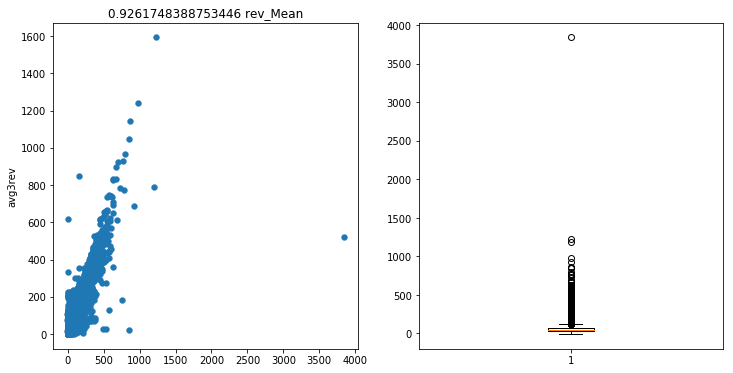

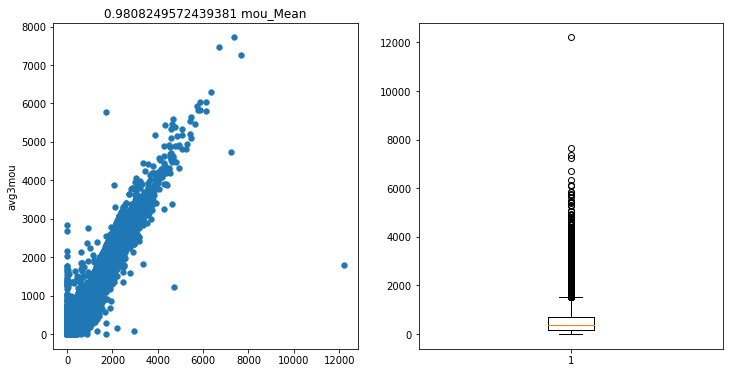

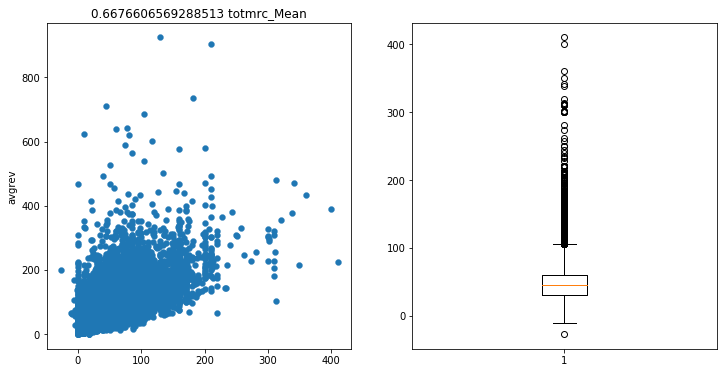

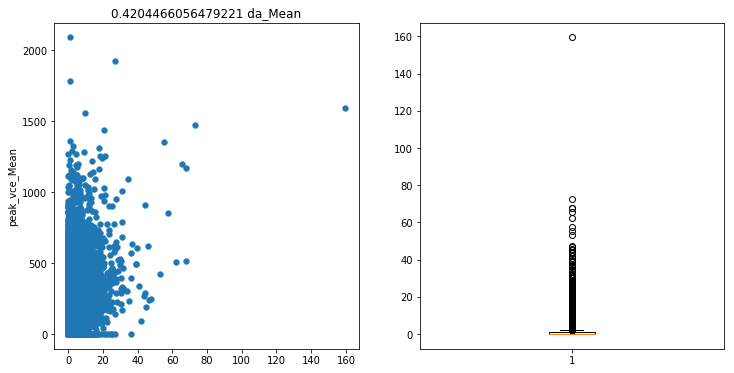

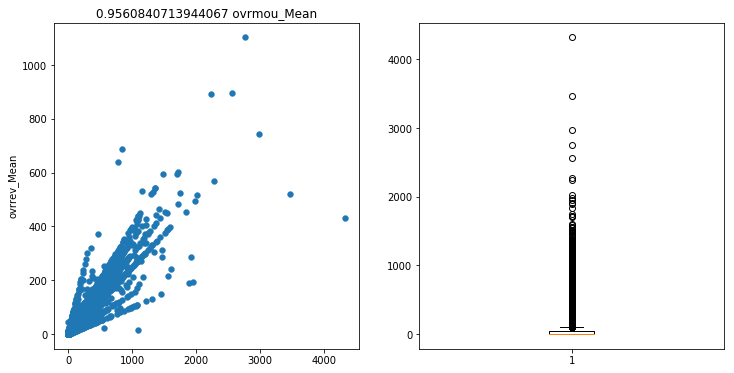

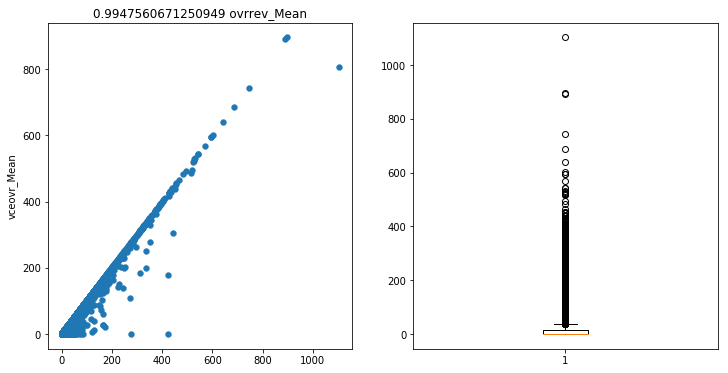

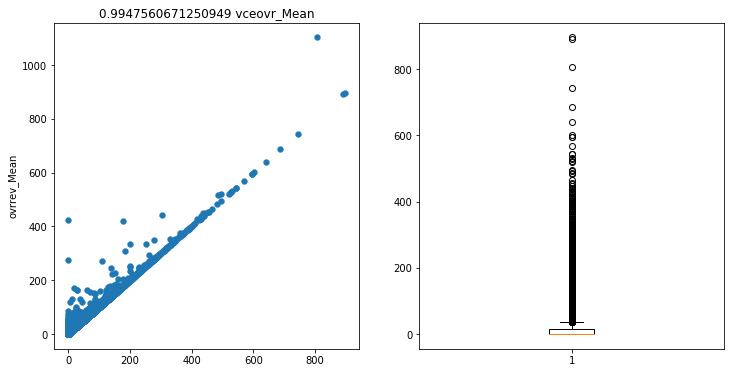

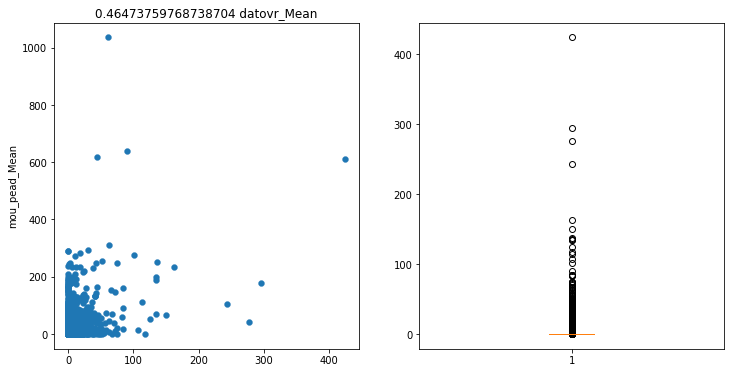

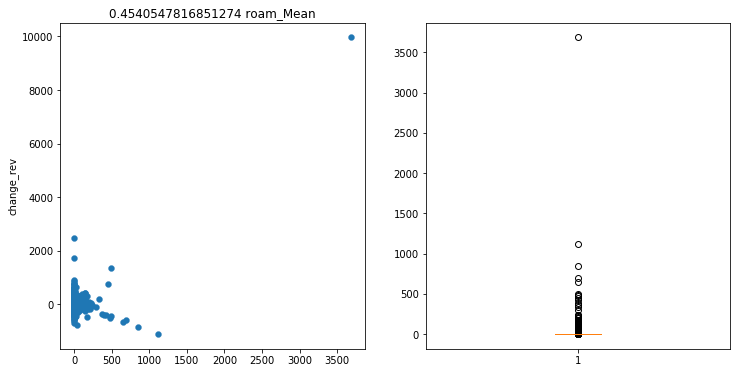

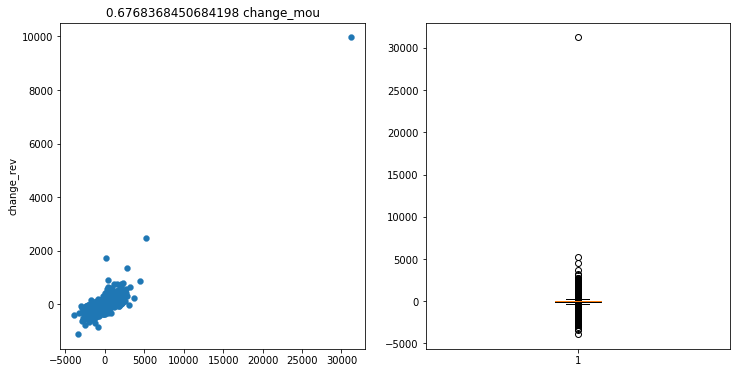

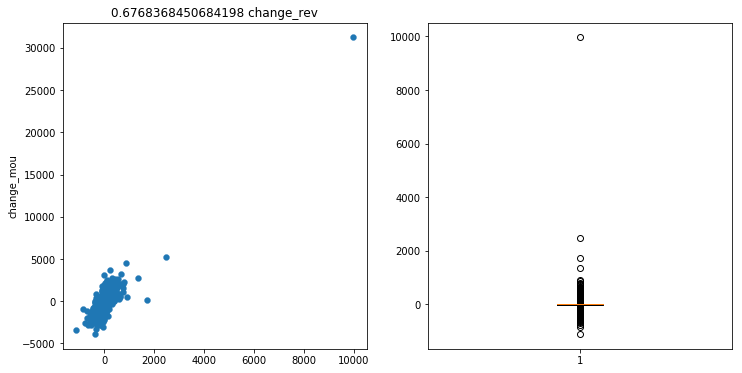

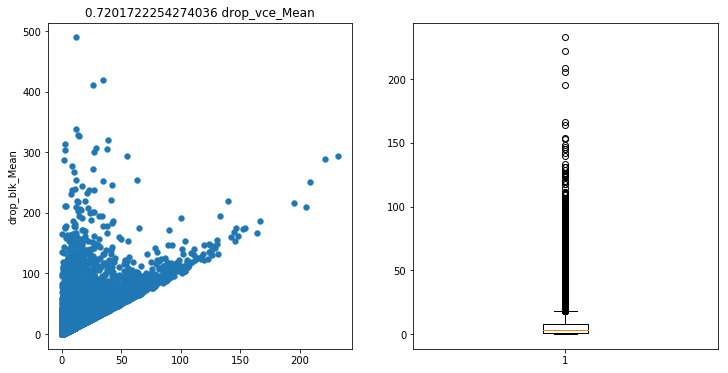

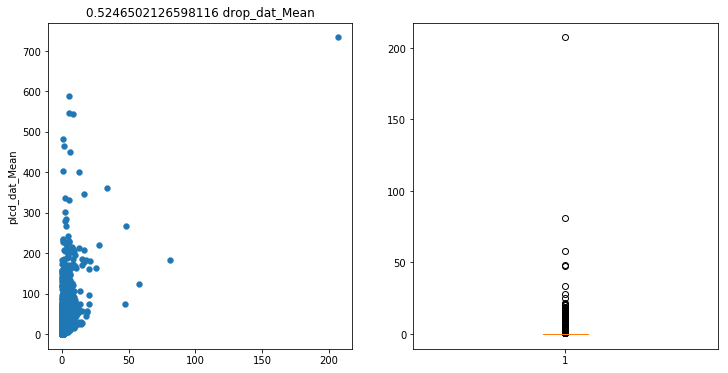

In [35]:
for i in a1:
    highest_cor=data_1.corr()[i].sort_values(ascending=False).index[1]
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title(label=str(data_1.corr()[i].sort_values(ascending=False)[1])+' '+i)
    plt.scatter(x=data_1[i],y=data_1[highest_cor],lw=0.3,)
    plt.ylabel(highest_cor)
    plt.subplot(1,2,2)
    plt.boxplot(x=data_1[i])

## a1
#rev_Mean outliers >3500 
#mou_Mean outliers >12000
#totmrc_Mean outliers >380,320?
#o
vrmou_Mean outliers >4000 ,>3000?
#ovrrev_Mean outliers >1000
#vceovr_Mean outliers same as ovrrev_Mean
#dataovr_Mean outliers >400 ,>300?
#roam_Mean outliers >3500
#change_mou outliers >30000
#change_rev outliers same as change_mou
#drop_vce_Mean no outliers 
#drop_dat_Mean outliers >300

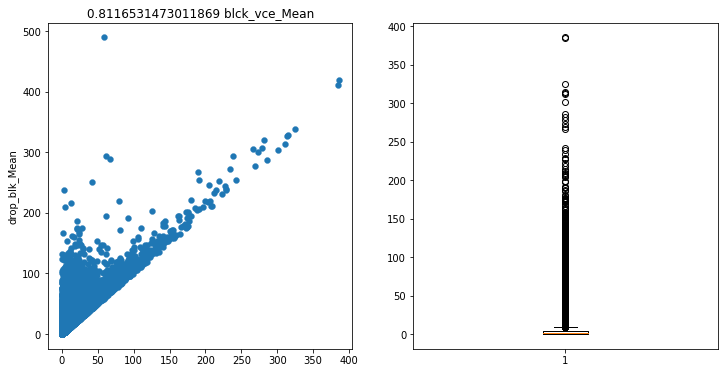

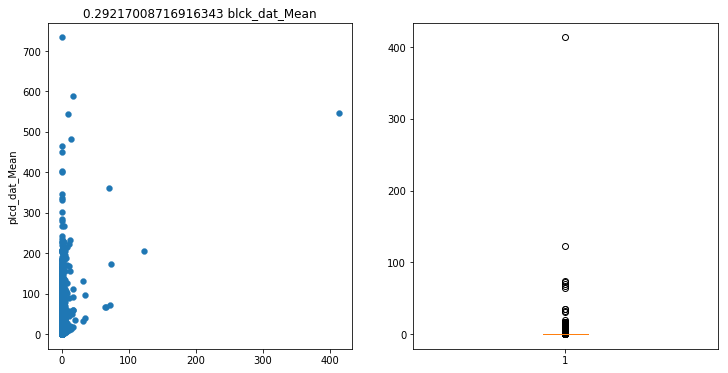

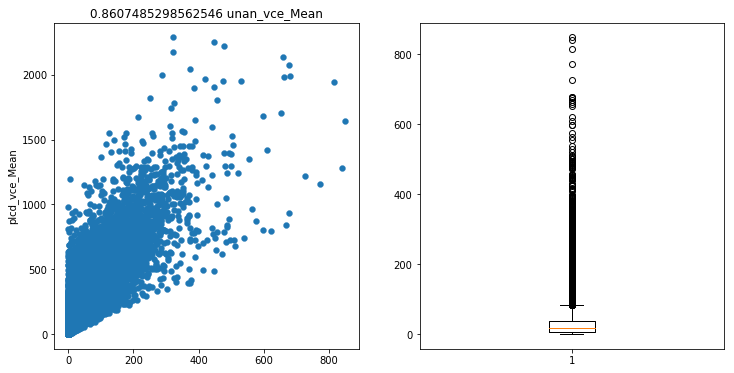

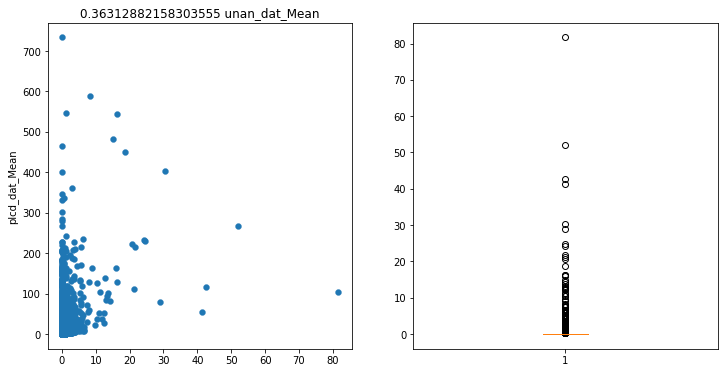

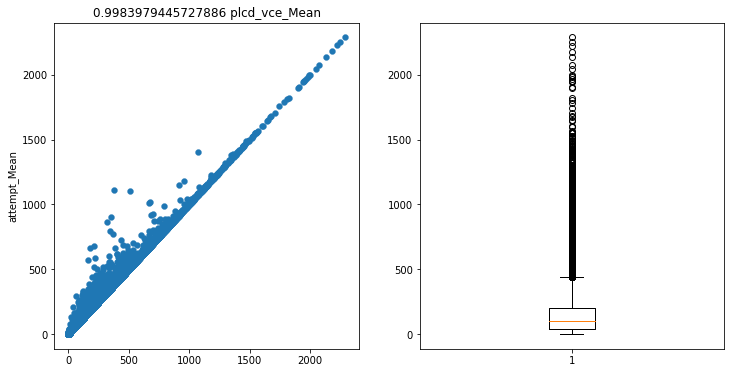

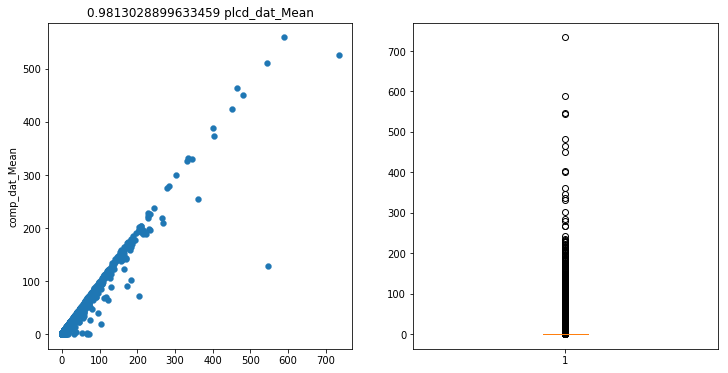

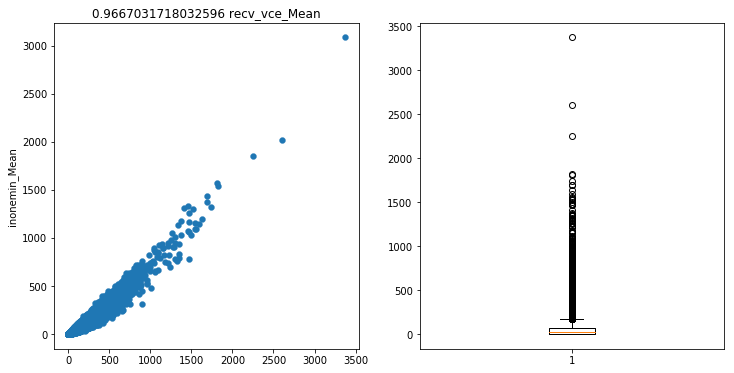

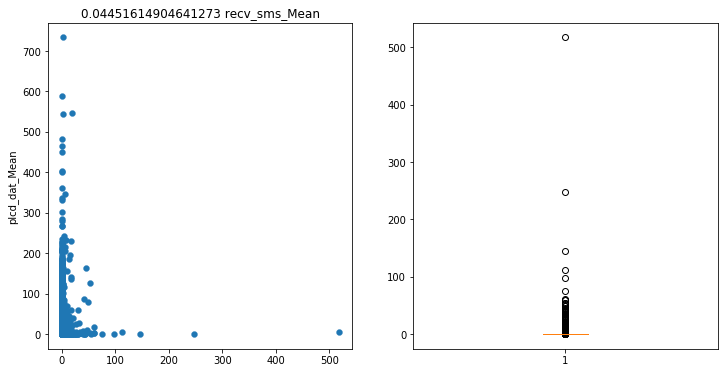

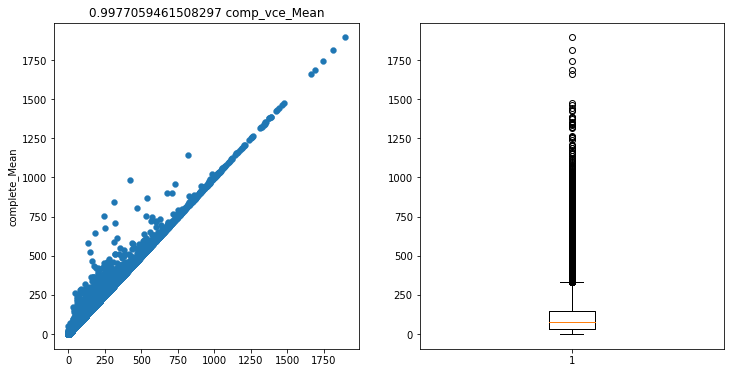

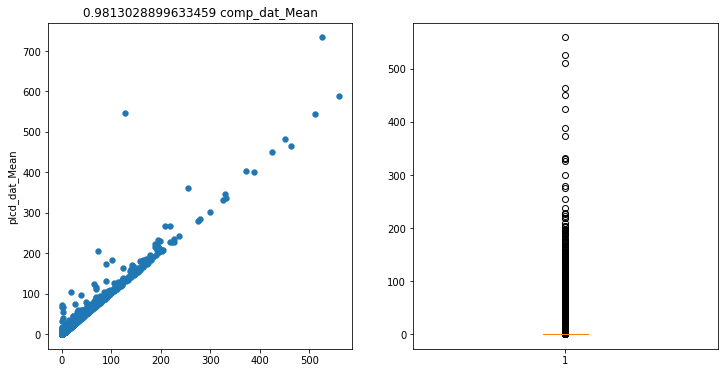

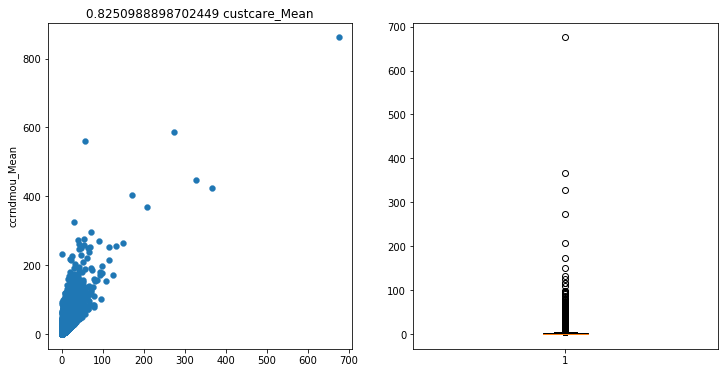

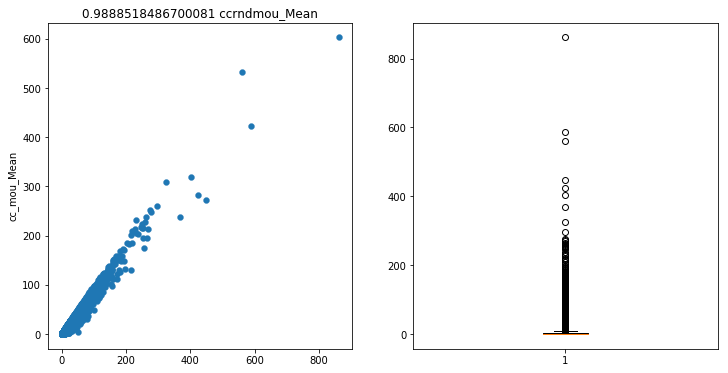

In [36]:
for i in a2:
    highest_cor=data_1.corr()[i].sort_values(ascending=False).index[1]
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title(label=str(data_1.corr()[i].sort_values(ascending=False)[1])+' '+i)
    plt.scatter(x=data_1[i],y=data_1[highest_cor],lw=0.3)
    plt.ylabel(highest_cor)
    plt.subplot(1,2,2)
    plt.boxplot(x=data_1[i])

## a2
#blck_vce_Mean outliers None
#blck_dat_Mean outliers >400,>100?
#unan_vce_Mean outliers None
#unan_dat_Mean outliers >50
#plcd_vce_Mean outliers None
#plcd_dat_Mean outliers >700,>500?
#recv_vce_Mean outliers >3500?
#recv_sms_Mean outliers >500,>200?
#comp_vce_Mean outliers None
#comp_dat_Mean ouliers None
#custcare_Mean outliers >600
#ccrndmou_Mean outliers >800(custcare),>400?

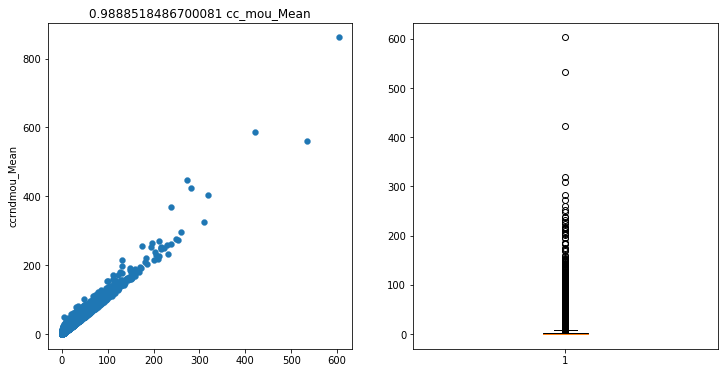

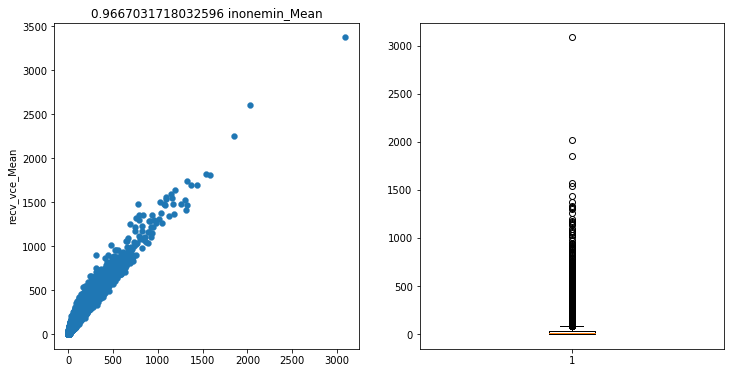

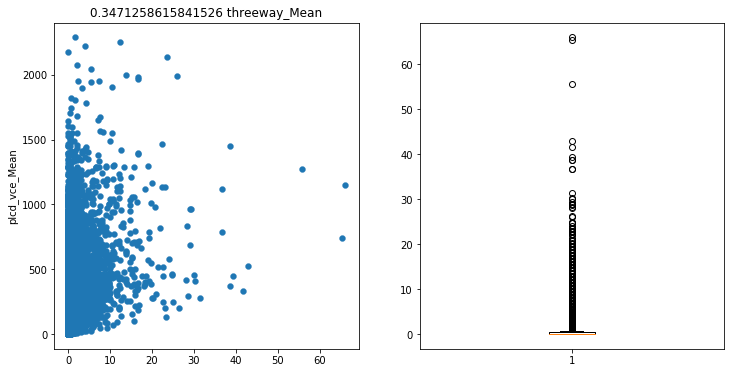

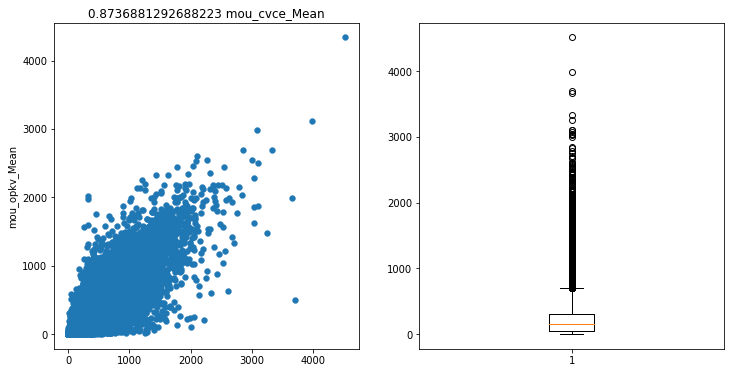

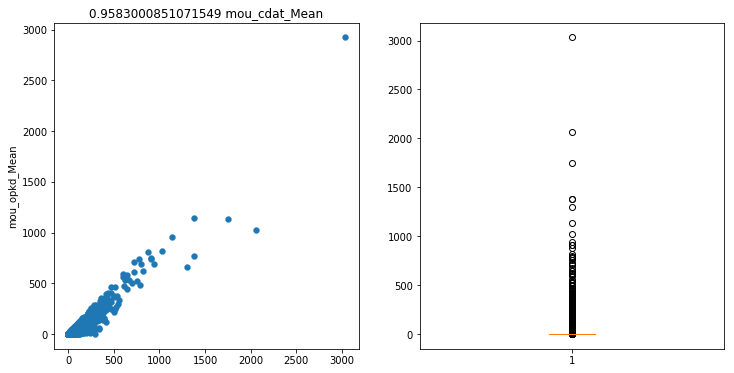

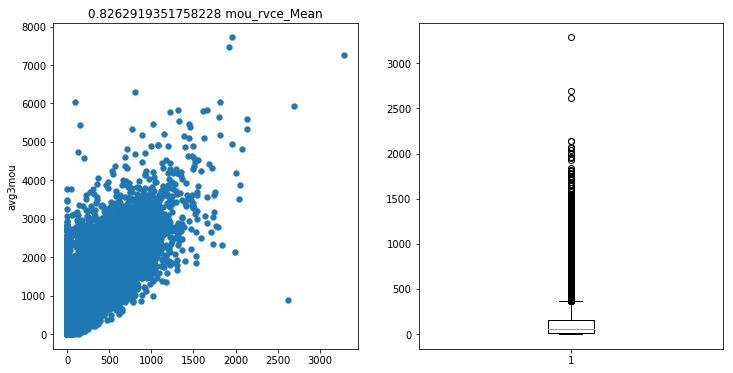

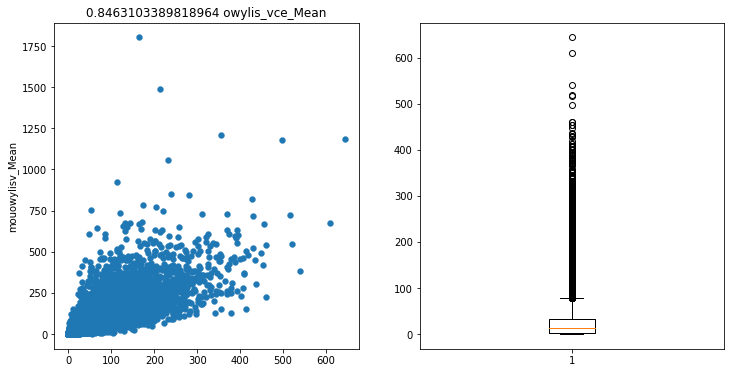

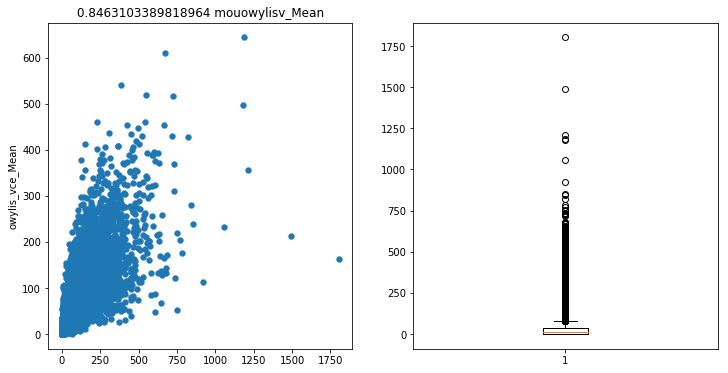

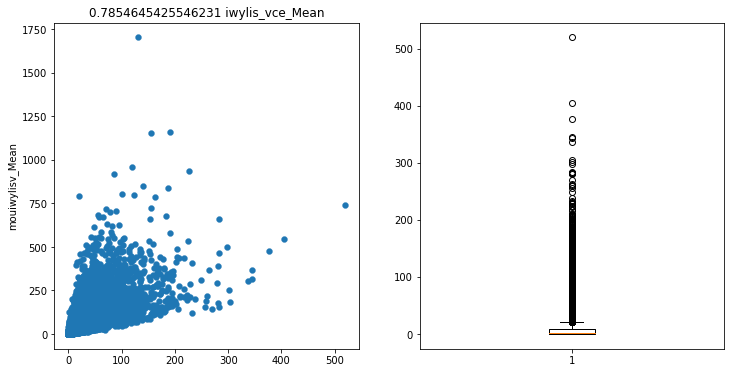

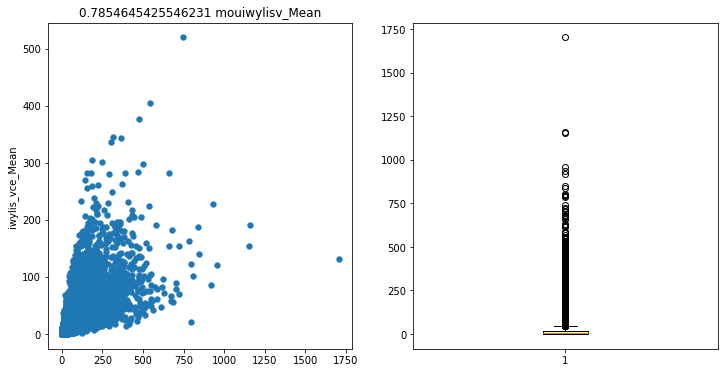

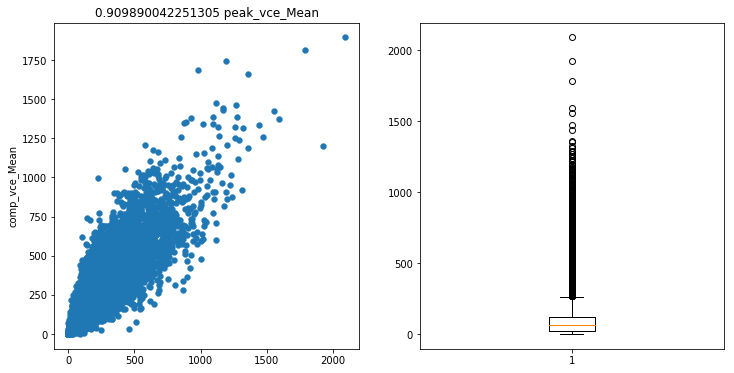

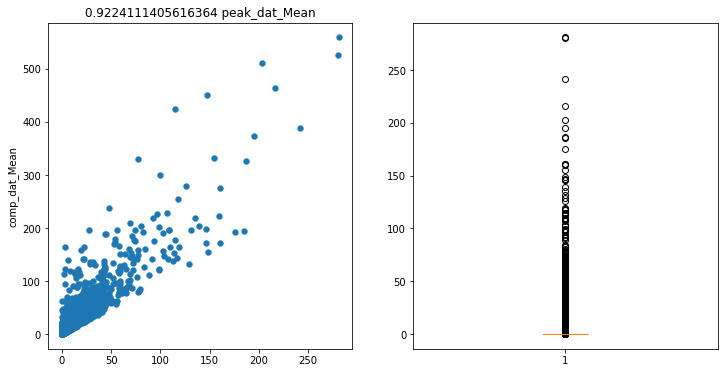

In [37]:
for i in a3:
    highest_cor=data_1.corr()[i].sort_values(ascending=False).index[1]
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title(label=str(data_1.corr()[i].sort_values(ascending=False)[1])+' '+i)
    plt.scatter(x=data_1[i],y=data_1[highest_cor],lw=0.3,)
    plt.ylabel(highest_cor)
    plt.subplot(1,2,2)
    plt.boxplot(x=data_1[i])

## a3
#cc_mou_Mean >800,>400?
#inonemin_Mean >3000
#threeway_Mean >50?
#mou_cvce_Mean >4000
#mou_cdat_Mean >3000
#mou_rcve_Mean >2500?
#owylis_vce_Mean >600?
#mouowylisv_Mean >1400?
#iwylis_vce_Mean >500
#mouiwylisv_Mean >1500
#peak_vce_Mean None 
#peak_dat_Mean None

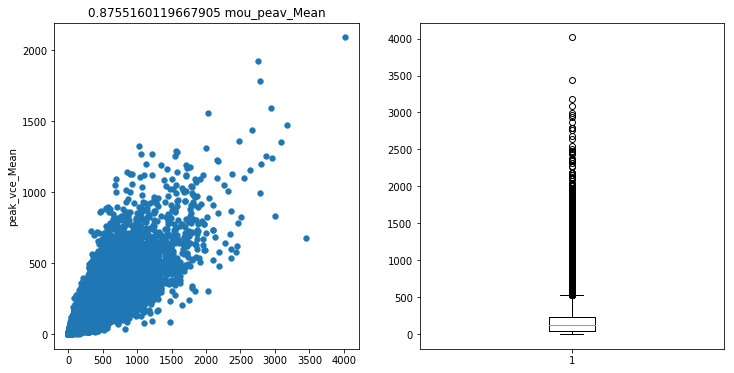

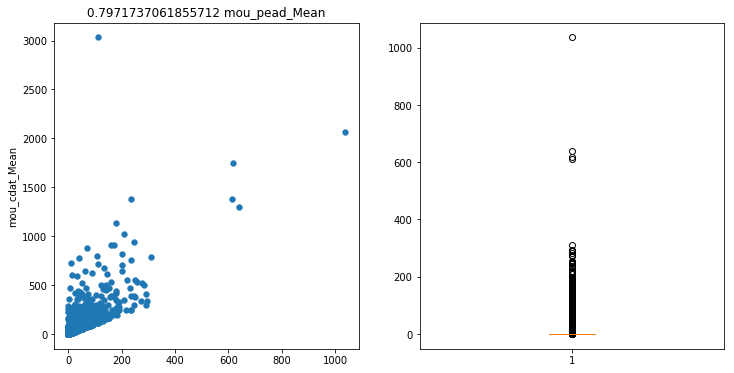

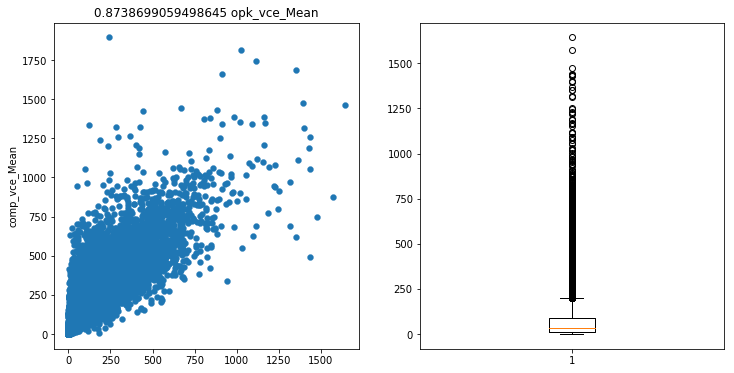

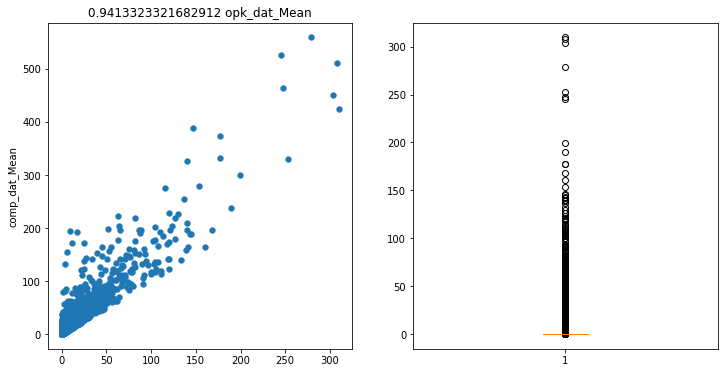

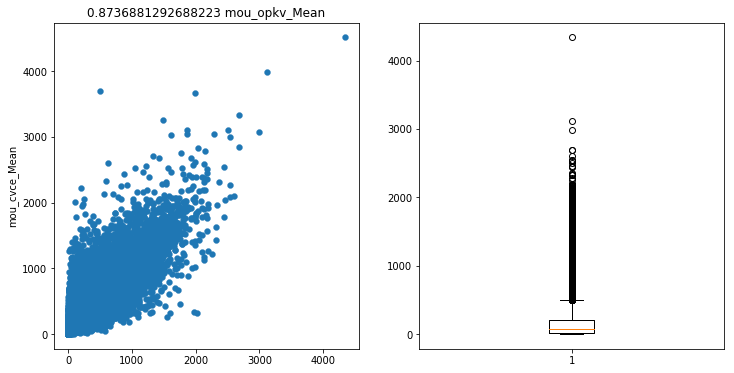

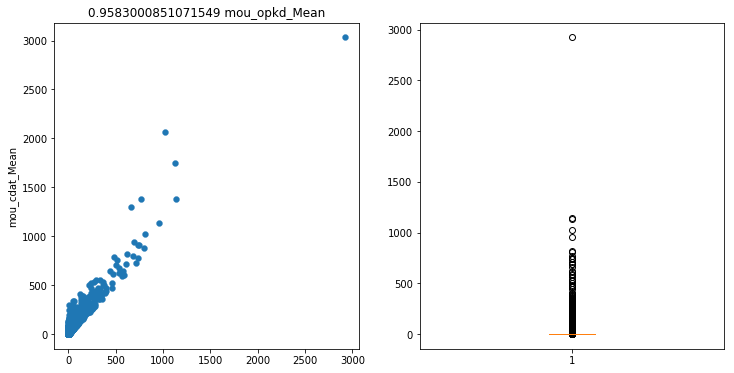

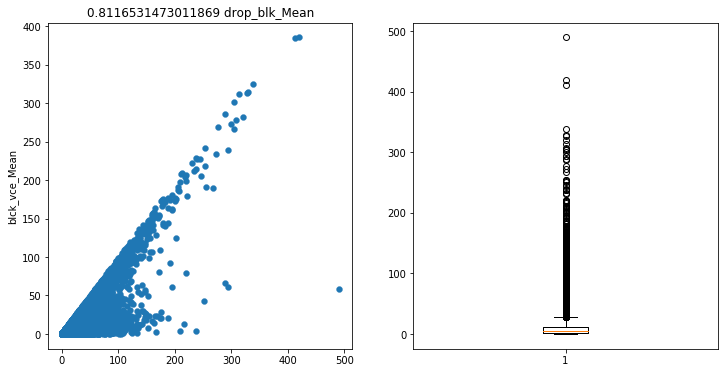

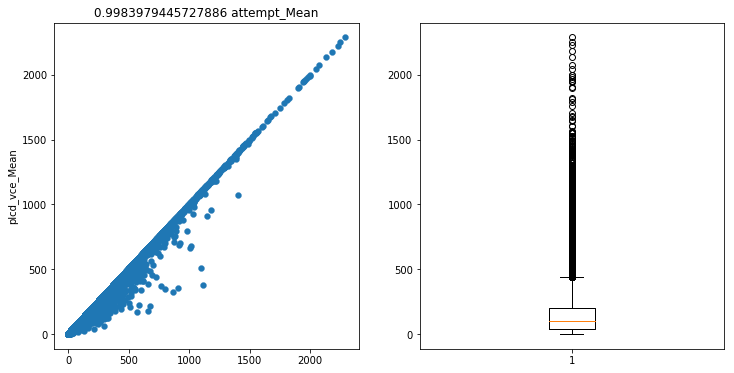

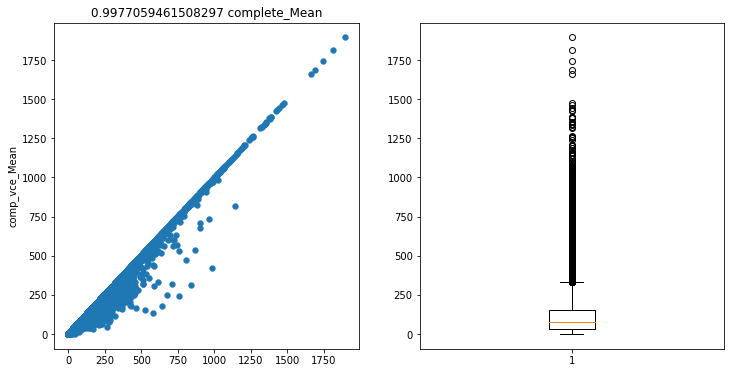

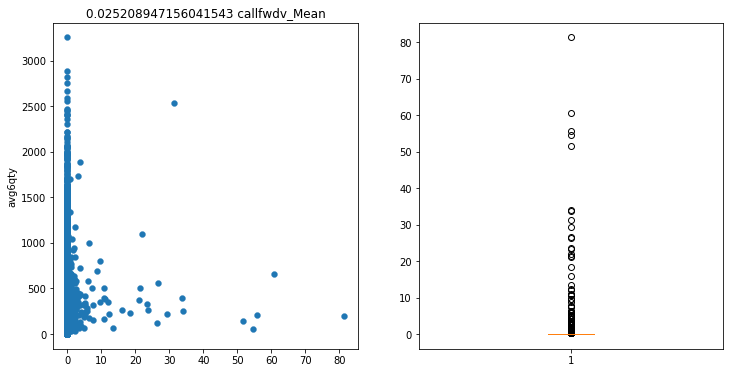

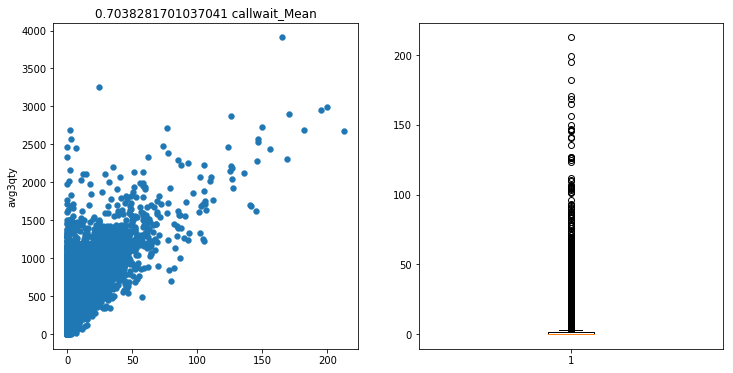

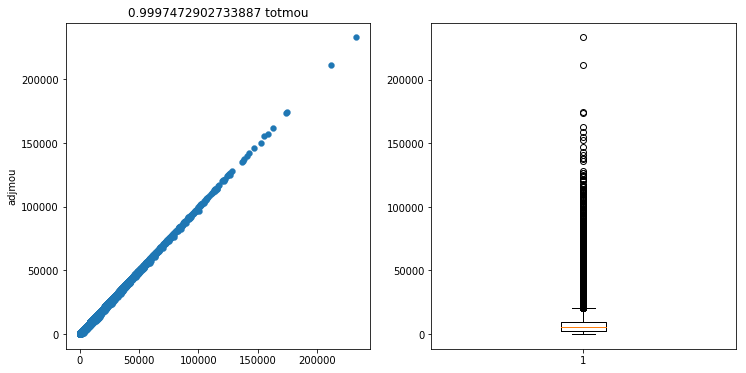

In [38]:
for i in a4:
    highest_cor=data_1.corr()[i].sort_values(ascending=False).index[1]
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title(label=str(data_1.corr()[i].sort_values(ascending=False)[1])+' '+i)
    plt.scatter(x=data_1[i],y=data_1[highest_cor],lw=0.3,)
    plt.ylabel(highest_cor)
    plt.subplot(1,2,2)
    plt.boxplot(x=data_1[i])

## a4
#mou_peav_Mean >3800
#mou_pead_Mean >1000
#opk_vce_Mean None 
#opk_dat_Mean None
#mou_opkv_Mean >4000
#mou_opkd_Mean >2500?
#drop_blk_Mean >470
#attempt_Mwan None
#complete_Mean None
#callfwd_Mean >60,>50?
#callwait_Mean None
#totmou None 

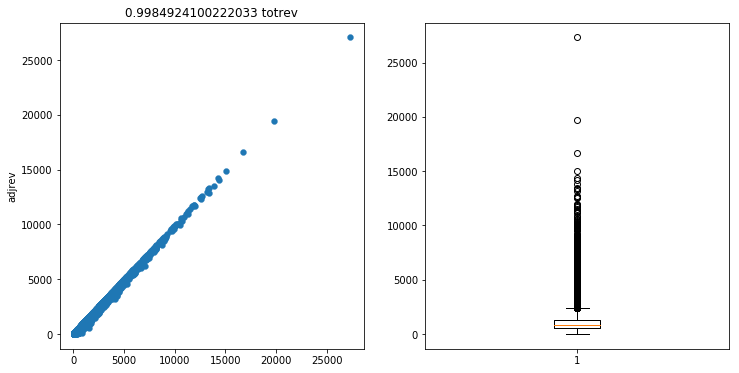

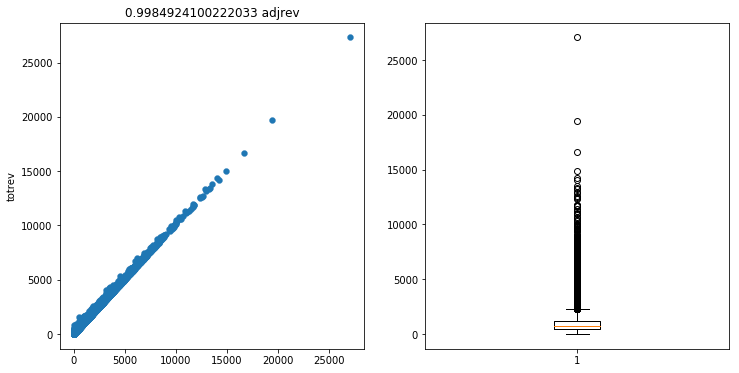

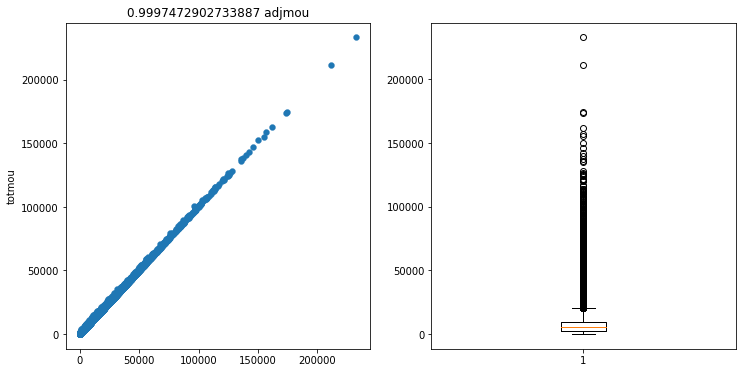

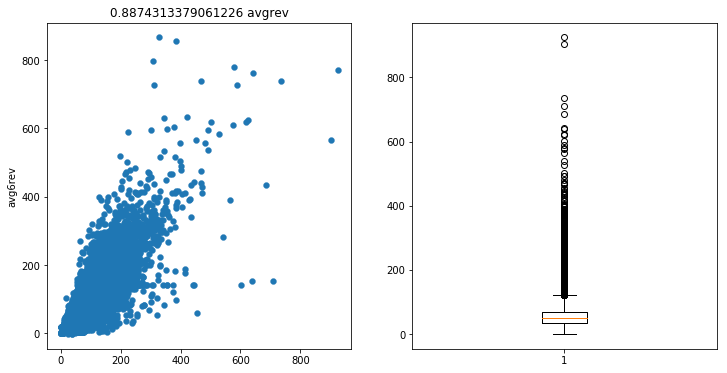

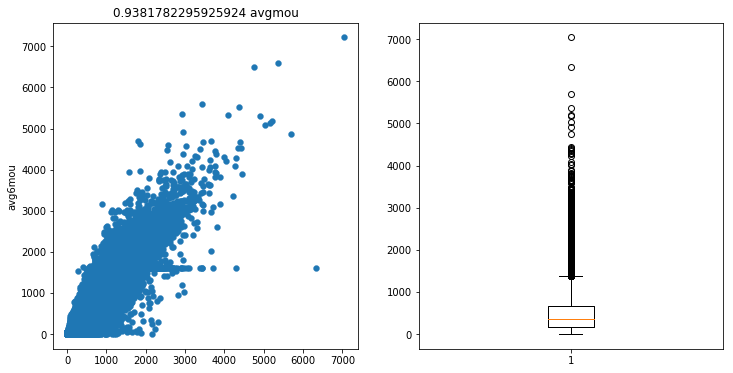

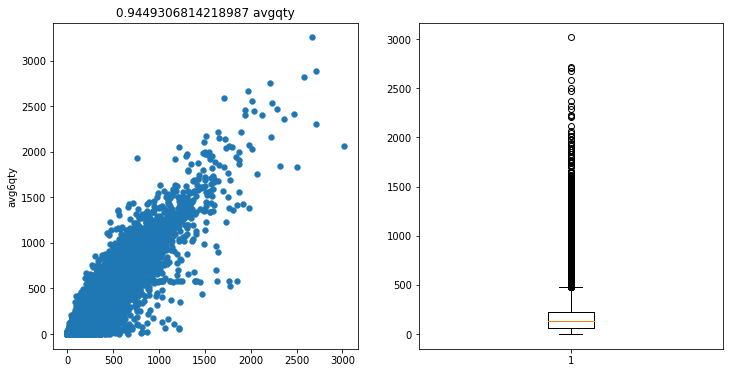

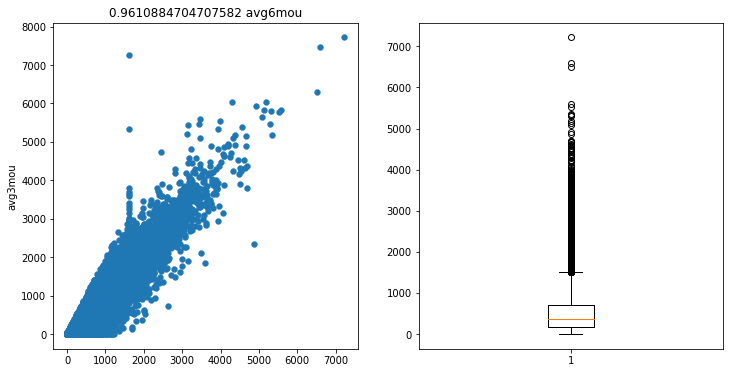

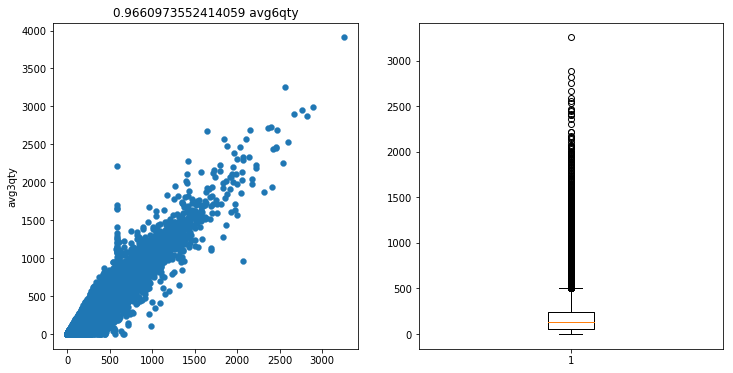

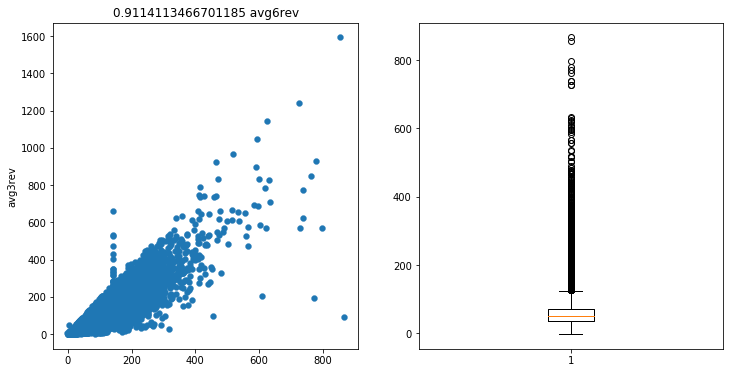

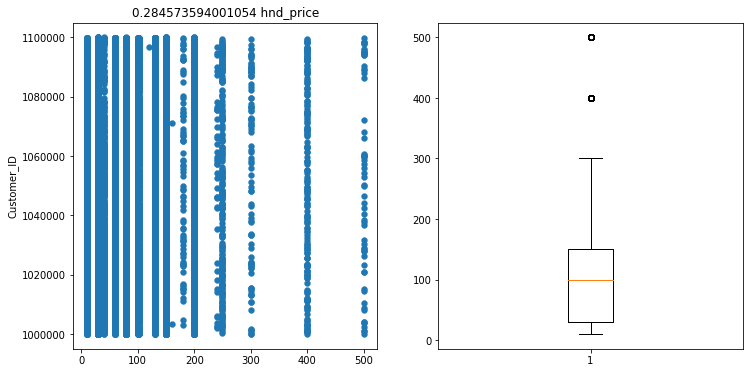

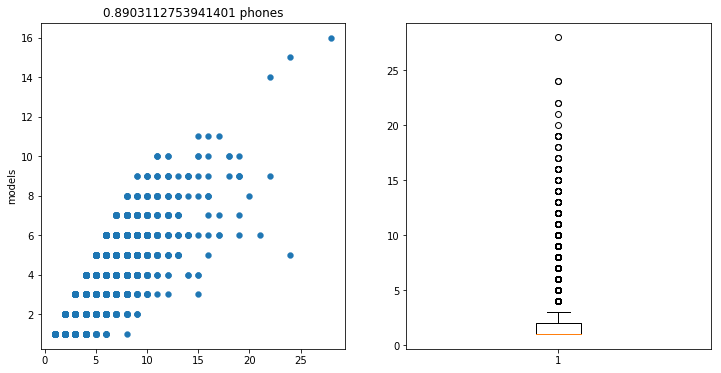

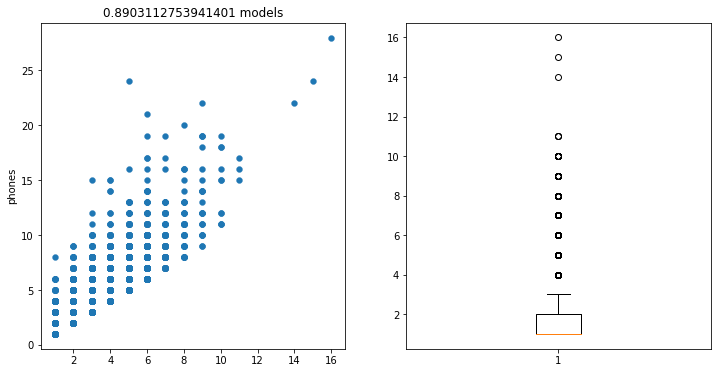

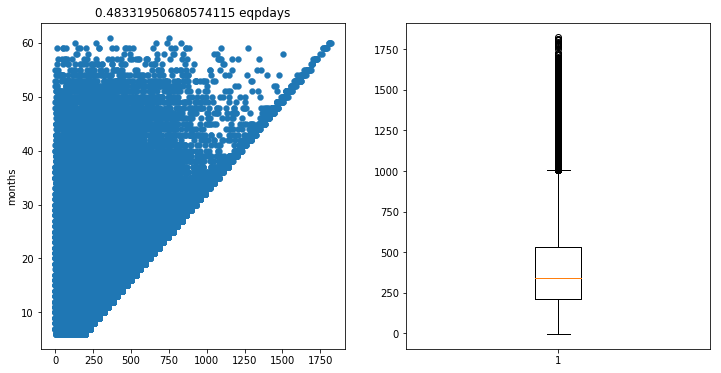

In [39]:
for i in a5:
    highest_cor=data_1.corr()[i].sort_values(ascending=False).index[1]
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title(label=str(data_1.corr()[i].sort_values(ascending=False)[1])+' '+i)
    plt.scatter(x=data_1[i],y=data_1[highest_cor],lw=0.3,)
    plt.ylabel(highest_cor)
    plt.subplot(1,2,2)
    plt.boxplot(x=data_1[i])

## a5
No outliers found in this list

## Final List of possible outliers - approximately 40 possible outliers 
#rev_Mean  >3500 
#mou_Mean  >12000
#totmrc_Mean  >380,320?
#vrmou_Mean  >4000 ,>3000?
#ovrrev_Mean  >1000
#vceovr_Mean  same as ovrrev_Mean
#dataovr_Mean  >400 ,>300?
#roam_Mean  >3500
#change_mou  >30000
#change_rev  same as change_mou
#drop_dat_Mean  >300
#blcl_dat_Mean  >400,>100?
#unan_dat_Mean  >50
#plcd_dat_Mean  >700,>500?
#recv_vce_Mean  >3500?
#recv_sms_Mean  >500,>200?
#custcare_Mean  >600
#ccrndmou_Mean  >800(custcare),>400?
#cc_mou_Mean >800,>400?
#inonemin_Mean >3000
#threeway_Mean >50?
#mou_cve_Mean >4000
#mou_cdat_Mean >3000
#mou_rcve_Mean >2500?
#owylis_vce_Mean >600?
#mouowylisv_Mean >1400?
#iwylis_vce_Mean >500
#mouiwylisv_Mean >1500
#mou_peav_Mean >3800
#mou_pead_Mean >1000
#mou_opkv_Mean >4000
#mou_opkd_Mean >2500?
#drop_blk_Mean >470
#callfwd_Mean >60,>50?

In [40]:
data_1.shape

(99999, 91)

In [41]:
data.shape

(100000, 100)

In [42]:
#creating a second copy of data_1 before removing or changin outliers 
data_2=data_1.copy()

In [43]:
index_list=[]

In [44]:
#FINDING INDEXES OF ALL THE OUTLIERS IN data_1
for i in data_1[data_1['ovrmou_Mean']>3000].index:
    index_list.append(i)
print(index_list)   

[651, 95471]


In [45]:
outliers_list=[39170, 39170, 2339, 39170, 39170, 12415, 77938, 16022, 10207, 30949, 
                     95471, 98554, 95471, 86930, 1810, 55234, 651, 96082, 95471, 95251, 55550, 
                     95251, 25840, 52868, 10207, 16022, 30949, 95471, 98554, 11380, 95775, 
                     95251, 86930, 23769, 71165, 47977, 63585, 95471, 651, 95471]

In [46]:
outliers_list_index=list(pd.Series(outliers_list).sort_values().unique())


In [47]:
outliers_list_index

[651,
 1810,
 2339,
 10207,
 11380,
 12415,
 16022,
 23769,
 25840,
 30949,
 39170,
 47977,
 52868,
 55234,
 55550,
 63585,
 71165,
 77938,
 86930,
 95251,
 95471,
 95775,
 96082,
 98554]

In [48]:
##REMOVING ALL OUTLIERS 
data_1.drop(outliers_list_index,inplace=True)

In [49]:
QualityReport=Data_Q(data_1)

In [50]:
#Removing customer ID 
data_1.drop(labels=['Customer_ID'],axis=1,inplace=True)

In [51]:
#data_1.to_csv('data_1.csv')

In [52]:
sample=pd.get_dummies(data_1,drop_first=True)

In [53]:
#sample=pd.read_csv('Cleaned_Data.csv')

In [54]:
#data_1=pd.read_csv('data_1.csv') 

In [55]:
#QualityReport=Data_Q(data_1)

In [56]:
obj_var=list(QualityReport[QualityReport['type']=='object']['variable_name'])

In [57]:
Data_obj=data_1.copy()

In [59]:
def obj_to_cat(x):
    QualityReport=Data_Q(x)
    obj_var=list(QualityReport[QualityReport['type']=='object']['variable_name'])
    for i in obj_var:
        x[i]=x[i].astype('category')
        x[i]=x[i].cat.codes
    return x
Data=obj_to_cat(Data_obj)

## Splitting of data into train and test data

In [61]:
y=Data['churn']
X=Data.drop('churn',axis=1)

In [62]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, random_state=100)

In [12]:
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,auc
from sklearn.model_selection import GridSearchCV

## Logistic Regressions

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [65]:
mod1=LogisticRegression()

In [66]:
mod1.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [67]:
predict_train=mod1.predict(X_train)
predict_test =mod1.predict(X_test)
df_train=mod1.decision_function(X_train)
df_test=mod1.decision_function(X_test)

In [68]:
print('Traning Set',classification_report(y_train,predict_train))
print('Test Set',classification_report(y_test,predict_test))
print('Auc Training Set',roc_auc_score(y_train,df_train))
print('Auc Test Set',roc_auc_score(y_test,df_test))

Traning Set               precision    recall  f1-score   support

           0       0.59      0.60      0.59     37828
           1       0.59      0.58      0.58     37153

   micro avg       0.59      0.59      0.59     74981
   macro avg       0.59      0.59      0.59     74981
weighted avg       0.59      0.59      0.59     74981

Test Set               precision    recall  f1-score   support

           0       0.59      0.60      0.60     12595
           1       0.59      0.58      0.58     12399

   micro avg       0.59      0.59      0.59     24994
   macro avg       0.59      0.59      0.59     24994
weighted avg       0.59      0.59      0.59     24994

Auc Training Set 0.6220877283863959
Auc Test Set 0.6208665741301667


## Feature Scaling

In [62]:
from sklearn.preprocessing import MinMaxScaler
Scalar=MinMaxScaler()
X_train_scalar=Scalar.fit_transform(X_train)
X_test_scalar=Scalar.fit_transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## K Nearest Neighbour Classification

In [119]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)

In [120]:
knn.fit(X_train_scalar,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [122]:
pred_train=knn.predict(X_train_scalar)
pred_test=knn.predict(X_test_scalar)

In [160]:
predict_proba_train=knn.predict_proba(X_train_scalar)
y_train_scores=[]
for i in predict_proba_train:
    y_train_scores.append(i[1])

In [162]:
predict_proba_test=knn.predict_proba(X_test_scalar)
y_test_scores=[]
for j in predict_proba_test:
    y_test_scores.append(j[1])

In [163]:
print('Training Set',classification_report(y_train,pred_train))
print('Test Set',classification_report(y_test,pred_test))
print('Auc Train Score',roc_auc_score(y_train,y_train_scores))
print('AUC Test Score',roc_auc_score(y_test,y_test_scores))

Training Set               precision    recall  f1-score   support

           0       0.70      0.70      0.70     37828
           1       0.70      0.70      0.70     37153

   micro avg       0.70      0.70      0.70     74981
   macro avg       0.70      0.70      0.70     74981
weighted avg       0.70      0.70      0.70     74981

Test Set               precision    recall  f1-score   support

           0       0.53      0.54      0.54     12595
           1       0.53      0.53      0.53     12399

   micro avg       0.53      0.53      0.53     24994
   macro avg       0.53      0.53      0.53     24994
weighted avg       0.53      0.53      0.53     24994

Auc Train Score 0.765046104061528
AUC Test Score 0.5401874730193925


## Decision Tree Classfier

In [69]:
from sklearn.tree import DecisionTreeClassifier

In [70]:
params_grid={'max_depth':[3,4,5,6,7,8,9,20]}

In [ ]:
dt=DecisionTreeClassifier()
model=GridSearchCV(dt,param_grid=params_grid,n_jobs=-1,scoring='roc_auc',cv=5)

In [190]:
model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [205]:
train=model.best_estimator_.predict(X_train)
test=model.best_estimator_.predict(X_test)

In [206]:
prob_train=model.predict_proba(X_train)
y_train_score=[]
for i in prob_train:
    y_train_score.append(i[1])

In [207]:
prob_test=model.predict_proba(X_test)
y_test_score=[]
for i in prob_test:
    y_test_score.append(i[1])

In [208]:
print('Training Data',classification_report(y_train,train))
print('Test Data',classification_report(y_test,test))
print('Auc Train Score',roc_auc_score(y_train,y_train_score))
print('AUC Test Score',roc_auc_score(y_test,y_test_score))

Training Data               precision    recall  f1-score   support

           0       0.63      0.61      0.62     37828
           1       0.61      0.64      0.63     37153

   micro avg       0.62      0.62      0.62     74981
   macro avg       0.62      0.62      0.62     74981
weighted avg       0.62      0.62      0.62     74981

Test Data               precision    recall  f1-score   support

           0       0.61      0.59      0.60     12595
           1       0.60      0.62      0.61     12399

   micro avg       0.60      0.60      0.60     24994
   macro avg       0.60      0.60      0.60     24994
weighted avg       0.60      0.60      0.60     24994

Auc Train Score 0.6782713343686614
AUC Test Score 0.6450303990182717


In [73]:
dtree = DecisionTreeClassifier(max_depth=8)

In [74]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [75]:
predictions_train = dtree.predict(X_train)
predictions_test=dtree.predict(X_test)

In [76]:
prob_train=dtree.predict_proba(X_train)
y_train_score=[]
for i in prob_train:
    y_train_score.append(i[1])

In [77]:
prob_test=dtree.predict_proba(X_test)
y_test_score=[]
for i in prob_test:
    y_test_score.append(i[1])

In [78]:
print('Training Data',classification_report(y_train,predictions_train))
print('Test Data',classification_report(y_test,predictions_test))
print('Auc Train Score',roc_auc_score(y_train,y_train_score))
print('AUC Test Score',roc_auc_score(y_test,y_test_score))

Training Data               precision    recall  f1-score   support

           0       0.63      0.61      0.62     37828
           1       0.61      0.64      0.63     37153

   micro avg       0.62      0.62      0.62     74981
   macro avg       0.62      0.62      0.62     74981
weighted avg       0.62      0.62      0.62     74981

Test Data               precision    recall  f1-score   support

           0       0.61      0.59      0.60     12595
           1       0.60      0.62      0.61     12399

   micro avg       0.60      0.60      0.60     24994
   macro avg       0.60      0.60      0.60     24994
weighted avg       0.60      0.60      0.60     24994

Auc Train Score 0.6782713343686614
AUC Test Score 0.6447578162397748


## Random Forest Classifier 

In [79]:
from sklearn.ensemble import RandomForestClassifier

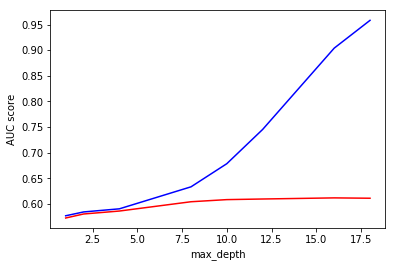

In [84]:
max_depth = [1, 2, 4, 8, 10,12,16,18]
train_results = []
test_results = []
for depth in max_depth:
   rf = RandomForestClassifier(max_depth=depth, n_jobs=-1,n_estimators=800)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1= plt.plot(max_depth , train_results, 'b', label='Train AUC')
line2= plt.plot(max_depth , test_results, 'r', label='Test AUC')
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.show()

In [74]:
from sklearn.model_selection import GridSearchCV

In [79]:
rfc=RandomForestClassifier()
params_grid={'max_depth':[1,2,3,4,5,6,7],
            'n_estimators':[100,400,800]}

In [82]:
model=GridSearchCV(rfc,params_grid,scoring='roc_auc',cv=5,n_jobs=-1)

In [83]:
model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7], 'n_estimators': [100, 400, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [93]:
model.best_params_

{'max_depth': 7, 'n_estimators': 800}

In [80]:
rfc = RandomForestClassifier(max_depth=7,n_estimators=800,random_state=100)

In [81]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

In [82]:
rfc_pred_train=rfc.predict(X_train)
rfc_pred_test=rfc.predict(X_test)

In [83]:
prob_train=rfc.predict_proba(X_train)
y_train_score=[]
for i in prob_train:
    y_train_score.append(i[1])

In [84]:
prob_test=rfc.predict_proba(X_test)
y_test_score=[]
for i in prob_test:
    y_test_score.append(i[1])

In [85]:
print('Training Data',classification_report(y_train,rfc_pred_train))
print('Test Data',classification_report(y_test,rfc_pred_test))
print('Auc Train Score',roc_auc_score(y_train,y_train_score))
print('AUC Test Score',roc_auc_score(y_test,y_test_score))

Training Data               precision    recall  f1-score   support

           0       0.64      0.56      0.60     37828
           1       0.60      0.69      0.64     37153

   micro avg       0.62      0.62      0.62     74981
   macro avg       0.62      0.62      0.62     74981
weighted avg       0.62      0.62      0.62     74981

Test Data               precision    recall  f1-score   support

           0       0.62      0.54      0.58     12595
           1       0.59      0.67      0.63     12399

   micro avg       0.61      0.61      0.61     24994
   macro avg       0.61      0.61      0.60     24994
weighted avg       0.61      0.61      0.60     24994

Auc Train Score 0.6834528028346504
AUC Test Score 0.6570177626728532


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


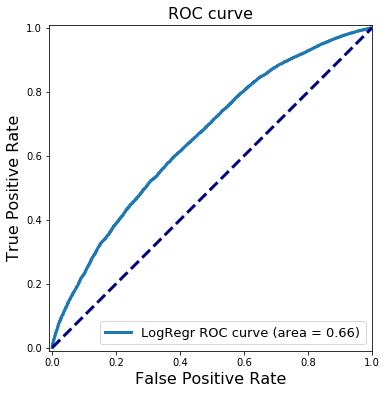

In [26]:
#plotting ROC curve 
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_score)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(12,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [69]:
imp_features=pd.DataFrame([rfc.feature_importances_,X_train.columns]).transpose().sort_values(by=0,ascending=False)

## Neural Network Classifier

In [60]:
from sklearn.neural_network import MLPClassifier

In [ ]:
nnclf = MLPClassifier(hidden_layer_sizes = [100], solver='lbfgs',
                         random_state = 0).fit(X_train_scalar, y_train)

In [149]:
pre_train=nnclf.predict(X_train_scalar)
pre_test=nnclf.predict(X_test_scalar)

In [150]:
prob_train=nnclf.predict_proba(X_train_scalar)
y_train_score=[]
for i in prob_train:
    y_train_score.append(i[1])

In [151]:
prob_test=nnclf.predict_proba(X_test)
y_test_score=[]
for i in prob_test:
    y_test_score.append(i[1])

In [153]:
print('Training Data',classification_report(y_train,pre_train))
print('Test Data',classification_report(y_test,pre_test))
print('Auc Train Score',roc_auc_score(y_train,y_train_score))
print('AUC Test Score',roc_auc_score(y_test,y_test_score))

Training Data               precision    recall  f1-score   support

           0       0.62      0.58      0.60     37828
           1       0.60      0.63      0.61     37153

   micro avg       0.61      0.61      0.61     74981
   macro avg       0.61      0.61      0.61     74981
weighted avg       0.61      0.61      0.61     74981

Test Data               precision    recall  f1-score   support

           0       0.60      0.61      0.60     12595
           1       0.59      0.58      0.59     12399

   micro avg       0.60      0.60      0.60     24994
   macro avg       0.60      0.60      0.60     24994
weighted avg       0.60      0.60      0.60     24994

Auc Train Score 0.6480752098952105
AUC Test Score 0.5102495651965939


## Support Vector Machine Classifer - Extremely Slow 

In [209]:
from sklearn.svm import SVC

In [210]:
sv=SVC()

In [211]:
sv.fit(X_train_scalar,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [213]:
pred_sv=sv.predict(X_test_scalar)

In [214]:
pred_sv_train=sv.predict(X_train_scalar)

In [216]:
y_train_score=sv.decision_function(X_train_scalar)
y_test_score=sv.decision_function(X_test_scalar)

In [217]:
print('Training Data',classification_report(y_train,pred_sv_train))
print('Test Data',classification_report(y_test,pred_sv))
print('Auc Train Score',roc_auc_score(y_train,y_train_score))
print('AUC Test Score',roc_auc_score(y_test,y_test_score))

Training Data               precision    recall  f1-score   support

           0       0.58      0.56      0.57     37828
           1       0.57      0.59      0.58     37153

   micro avg       0.58      0.58      0.58     74981
   macro avg       0.58      0.58      0.58     74981
weighted avg       0.58      0.58      0.58     74981

Test Data               precision    recall  f1-score   support

           0       0.58      0.57      0.58     12595
           1       0.57      0.58      0.58     12399

   micro avg       0.58      0.58      0.58     24994
   macro avg       0.58      0.58      0.58     24994
weighted avg       0.58      0.58      0.58     24994

Auc Train Score 0.6057156170708163
AUC Test Score 0.6040108178888915


## Adaboost classifier 

In [6]:
from sklearn.ensemble import AdaBoostClassifier

In [45]:
Ada=AdaBoostClassifier()

In [49]:
params_grid={'learning_rate':[0.5,0.7,0.9],
            'n_estimators':[100,200,300]}

In [50]:
model=GridSearchCV(Ada,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)

In [51]:
model.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 1, 2], 'n_estimators': [50, 100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [75]:
model.scorer_

make_scorer(roc_auc_score, needs_threshold=True)

In [56]:
model.best_score_

0.6688944901832955

In [160]:
best_pred=model.predict(X_test)

In [161]:
best_pred_train=model.predict(X_train)

In [186]:
prob_train=model.predict_proba(X_train)
y_train_score=[]
for i in prob_train:
    y_train_score.append(i[1])

In [187]:
prob_test=model.predict_proba(X_test)
y_test_score=[]
for i in prob_test:
    y_test_score.append(i[1])

In [188]:
print('Training Data',classification_report(y_train,best_pred_train))
print('Test Data',classification_report(y_test,best_pred))
print('AUC Train Score',roc_auc_score(y_train,y_train_score))
print('AUC Test Score',roc_auc_score(y_test,y_test_score))
print('Test Set confusion Matrix')
print(confusion_matrix(y_test,best_pred_test))

Training Data               precision    recall  f1-score   support

           0       0.68      0.67      0.68     37828
           1       0.67      0.68      0.68     37153

   micro avg       0.68      0.68      0.68     74981
   macro avg       0.68      0.68      0.68     74981
weighted avg       0.68      0.68      0.68     74981

Test Data               precision    recall  f1-score   support

           0       0.64      0.63      0.64     12595
           1       0.63      0.64      0.64     12399

   micro avg       0.64      0.64      0.64     24994
   macro avg       0.64      0.64      0.64     24994
weighted avg       0.64      0.64      0.64     24994

AUC Train Score 0.745944422977292
AUC Test Score 0.6928133346819034
Test Set confusion Matrix
[[7969 4626]
 [4429 7970]]


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


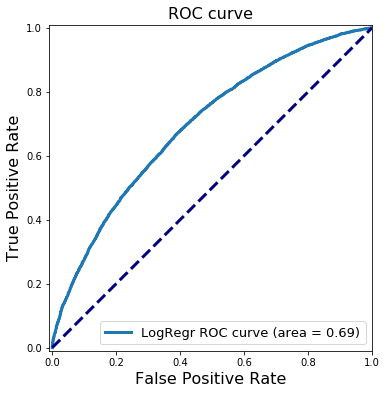

In [165]:
#plotting ROC curve 
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_score)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(12,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

## Gradient Boosting- Best Model

In [145]:
gdb=GradientBoostingClassifier()

In [126]:
params_grid={'learning_rate':[0.1,0.3,0.5,0.7],
            'n_estimators':[50,100,200]}

In [127]:
gdb_model=GridSearchCV(gdb,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)

In [128]:
gdb_model.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [130]:
gdb_model.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [138]:
gdb_model.best_score_

0.6838501756602455

In [167]:
best_pred_test=gdb_model.predict(X_test)

In [134]:
best_pred_train=gdb_model.predict(X_train)

In [135]:
prob_train=gdb_model.predict_proba(X_train)
y_train_score=[]
for i in prob_train:
    y_train_score.append(i[1])

In [136]:
prob_test=gdb_model.predict_proba(X_test)
y_test_score=[]
for i in prob_test:
    y_test_score.append(i[1])

In [170]:
print('Training Data',classification_report(y_train,best_pred_train))
print('Test Data',classification_report(y_test,best_pred))
print('Auc Train Score',roc_auc_score(y_train,y_train_score))
print('AUC Test Score',roc_auc_score(y_test,y_test_score))
print('Test Set confusion matrix')
print(confusion_matrix(y_test,best_pred_test))

Training Data               precision    recall  f1-score   support

           0       0.68      0.67      0.68     37828
           1       0.67      0.68      0.68     37153

   micro avg       0.68      0.68      0.68     74981
   macro avg       0.68      0.68      0.68     74981
weighted avg       0.68      0.68      0.68     74981

Test Data               precision    recall  f1-score   support

           0       0.64      0.63      0.64     12595
           1       0.63      0.64      0.64     12399

   micro avg       0.64      0.64      0.64     24994
   macro avg       0.64      0.64      0.64     24994
weighted avg       0.64      0.64      0.64     24994

Auc Train Score 0.6684104930026211
AUC Test Score 0.6928133346819034
Test Set confusion matrix
[[7969 4626]
 [4429 7970]]


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


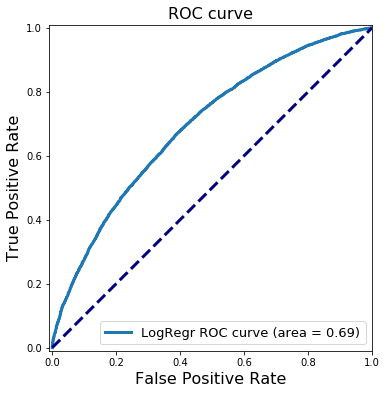

In [146]:
#plotting ROC curve 
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_score)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(12,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

## XGBOOST 

In [3]:
Data=pd.read_csv('Data.csv')

In [4]:
Data.drop('Unnamed: 0',axis=1,inplace=True)

In [35]:
y=Data['churn']
X=Data.drop('churn',axis=1)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, random_state=100)

In [36]:
import xgboost as xgb

In [37]:
Dmatrix=xgb.DMatrix(data=X,label=y)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [38]:
xgb_model=xgb.XGBClassifier(objective='binary:logistic',n_estimators=200,random_state=101,learning_rate=0.3,colsample_bytree=0.4)

In [39]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=101,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [40]:
pred=xgb_model.predict(X_test)

In [41]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     12595
           1       0.63      0.64      0.64     12399

   micro avg       0.64      0.64      0.64     24994
   macro avg       0.64      0.64      0.64     24994
weighted avg       0.64      0.64      0.64     24994



In [42]:
pred_prob=xgb_model.predict_proba(X_test)
y_test_score=[]
for i in pred_prob:
    y_test_score.append(i[1])

In [43]:
print(roc_auc_score(y_test,y_test_score))

0.6910831595512463


In [16]:
## cross validation for xgboost

In [22]:
params={'objective':'reg:logistic','max_depth':3,'n_estimators':200,'learning_rate':0.3,
       'colsample_bytree':0.4
       }

In [23]:
xgb.cv(params,Dmatrix,nfold=3,num_boost_round=100,metrics='auc',as_pandas=True,seed=101,verbose_eval=True)

[0]	train-auc:0.559369+0.00100305	test-auc:0.554776+0.0017082
[1]	train-auc:0.609569+0.0137636	test-auc:0.604372+0.0142329
[2]	train-auc:0.621339+0.0121133	test-auc:0.614443+0.0126397
[3]	train-auc:0.632594+0.00262947	test-auc:0.625541+0.00397278
[4]	train-auc:0.637032+0.00116979	test-auc:0.630192+0.00298865
[5]	train-auc:0.639857+0.00151827	test-auc:0.633277+0.00375316
[6]	train-auc:0.644955+0.000370598	test-auc:0.638374+0.00267058
[7]	train-auc:0.650088+0.00156272	test-auc:0.642916+0.00470541
[8]	train-auc:0.653829+0.000955014	test-auc:0.645722+0.00424597
[9]	train-auc:0.656125+0.000497163	test-auc:0.647963+0.00404713
[10]	train-auc:0.658993+0.00114966	test-auc:0.650233+0.00273188
[11]	train-auc:0.661451+0.0012742	test-auc:0.651813+0.00305208
[12]	train-auc:0.663472+0.001843	test-auc:0.65375+0.00271521
[13]	train-auc:0.665158+0.00198181	test-auc:0.654992+0.00262915
[14]	train-auc:0.666865+0.00216498	test-auc:0.656799+0.00240715
[15]	train-auc:0.669405+0.00221098	test-auc:0.659162+0.0

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.559369,0.001003,0.554776,0.001708
1,0.609569,0.013764,0.604372,0.014233
2,0.621339,0.012113,0.614443,0.012640
3,0.632594,0.002629,0.625541,0.003973
4,0.637032,0.001170,0.630192,0.002989
5,0.639857,0.001518,0.633277,0.003753
6,0.644955,0.000371,0.638374,0.002671
7,0.650088,0.001563,0.642916,0.004705
8,0.653829,0.000955,0.645722,0.004246
9,0.656125,0.000497,0.647963,0.004047


In [24]:
imp_features=pd.DataFrame([xgb_model.feature_importances_,X_train.columns]).transpose().sort_values(by=0,ascending=False)

In [26]:
imp_features

,0,1
48,0.063415,months
73,0.049854,hnd_price
79,0.045849,marital
75,0.035118,models
88,0.030991,eqpdays
53,0.030741,asl_flag
72,0.030058,refurb_new
1,0.021468,mou_Mean
63,0.020880,avg3mou
2,0.020244,totmrc_Mean


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


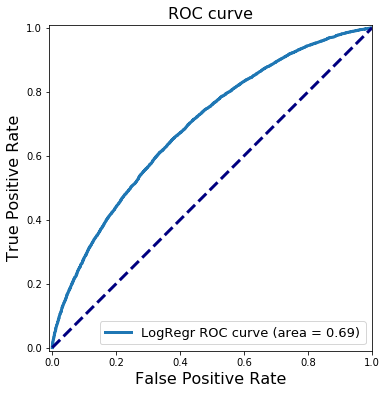

In [44]:
#plotting ROC curve 
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_score)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(12,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

## THE END 